
# **EMOTIONAL SPEECH RECOGNITION ANALYSIS**

## English
El siguiente analisis presenta una clasificacion emocional del discurso, reconociendo 7 emociones (enfado, sorpresa, asco, miedo, felicidad, tristeza y neutral) para el idioma **ingles**.

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [1]:
# IMPORT LIBRARIES
# Analysis
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Files
import os

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils, to_categorical
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile



In [2]:
AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}


## **1. CARGA DE DATOS**


<_explicacion detallada del dataset_>



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
Size of the dataset: 1440 

neutral     288
sad         192
angry       192
surprise    192
happy       192
fear        192
disgust     192
Name: emotion, dtype: int64


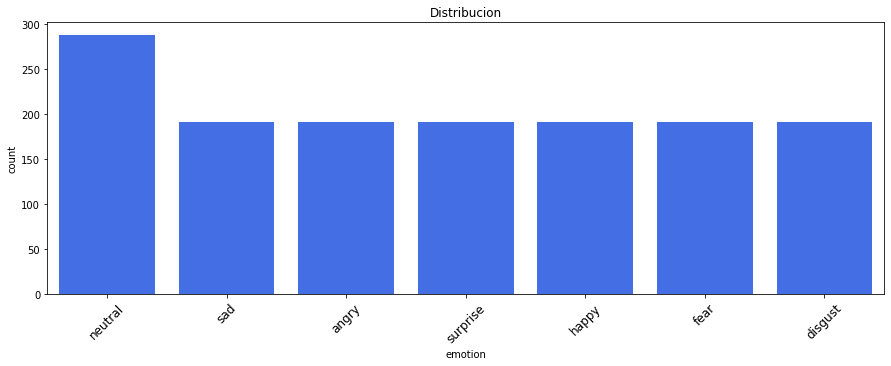

In [5]:
# Imprimimos la distribucion de las clases

df_aux = pd.DataFrame()
df_aux['emotion'] = list(class_distribution.keys())
df_aux['count']  = list(class_distribution)
fig, axs = plt.subplots(figsize=(15, 5))
axs = sns.barplot(x = 'emotion', y = 'count', color = '#2962FF', data = df_aux)
axs.set_title('Distribucion')
axs.set_xticklabels(axs.get_xticklabels(),rotation=45, fontsize = 12)
plt.show()

In [6]:
# Imprimimos una muestra de 10 filas aleatorias
EnglishSpeech_df.sample(n = 10)

,emotion,gender,intensity,path
838,disgust,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
810,angry,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
975,happy,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1157,sad,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
547,neutral,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
971,sad,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1110,fear,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
974,neutral,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
743,sad,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
680,sad,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...


## **2. EXPLORACION DE LOS DATOS**

### **2.1 EXPOSICION DE UNA MUESTRA ALEATORIA**



In [7]:

def plot_audio_waveform(audio_sample):
  '''
  Muestra la forma de la onda sonora a partir de una muestra.

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio 
  
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  plt.figure(figsize=(12, 4))
  librosa.display.waveplot(sample, sr=sampling_rate)
  print(len(sample))
  

def log_specgram(audio_sample):
  '''
  Muestra el espectograma a partir de una muestra de audio

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  return  __log_specgram(sample, sampling_rate)


def __log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
  '''
  Muestra el especograma de una muestra de audio en una ventana de tiempo
  
  Arguments
  ---------
  audio: np.ndarray
    Muestra de audio
  sample_rate: int, optional
    Frecuencia de muestreo de la muestra de audio
  window_size: int, optional

  step_size: int, optional
  
  eps: int, optional
  '''
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Random audio sample: /content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/data/Actor_09/03-01-04-01-01-02-09.wav
75781


Text(0, 0.5, 'Hz')

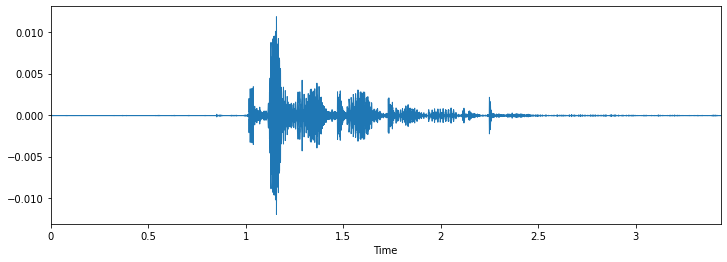

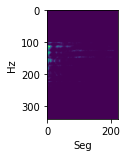

In [8]:
random_sample = EnglishSpeech_df.path[random.randint(0, len(EnglishSpeech_df))]
print("Random audio sample: {}".format(random_sample))
# Dibuja la grafica de la onda sonora
plot_audio_waveform(random_sample)

# Dibuja el espectograma
freqs, times, spectrogram = log_specgram(random_sample)

# Muestra la firgura
plt.figure(figsize=(30, 2))
plt.imshow(spectrogram)
plt.xlabel('Seg')
plt.ylabel('Hz')

In [11]:

# samplingFrequency, signalData = wavfile.read(random_sample)
# plt.plot(sample)
# plt.specgram(sample, Fs=sampling_rate)

### **2.2 COMPARATIVA DE TODAS LAS EMOCIONES**
Ahora que hemos conseguido extraer la grafica de una determinada muestra de sonido, vamos a comparar la graficas correspondientes a las muestras de sonido de distintas emociones respectivamente. Para ello vamos a distinguir por genero, ya que podria suponer una diferencia.

In [9]:
def plot_all_emotion_waveforms(gender, rows = 3, cols = 3):
  '''
  Muestra los graficos para todas las emociones con su correspondiente 
  etiqueta del dataset para un mismo genero (female/ male)
  
  Arguments
  --------- 
    gender: str
      Genero del actor en el audio
    rows:  int, optional
      Filas en las que se muestra. 5 por defecto
    cols: int, optional
      Columnas en las que se muestra. 2 por defecto
    
  '''
  labels = list(EnglishSpeech_df['emotion'].unique())
  files = dict()
  if not gender:
    return -1

  # Seleccionamos una muestra aleatoria correspondiente a cada emocion
  for label in labels:
    # Escogemos un archivo de audio al azar que cumpla estas dos condiciones
    index = EnglishSpeech_df[(EnglishSpeech_df['emotion'] == label) & 
                            (EnglishSpeech_df['gender'] == gender)].sample(n = 1).index[0]
    emotion_file = EnglishSpeech_df.iloc[index].path
    files[label] = emotion_file

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=1, wspace=0.4)
  for i, label in enumerate(labels):
    wfigure = files[label]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label.capitalize())
    data_sample, sample_rate = librosa.load(wfigure)
    librosa.display.waveplot(data_sample, sr= sample_rate)

    ## TODO: return image figure


### 2.2.1 COMPARATIVA DE EMOCIONES PARA HOMBRE
En primer lugar vemos que aspecto tienen las emociones para la **voz masculina**

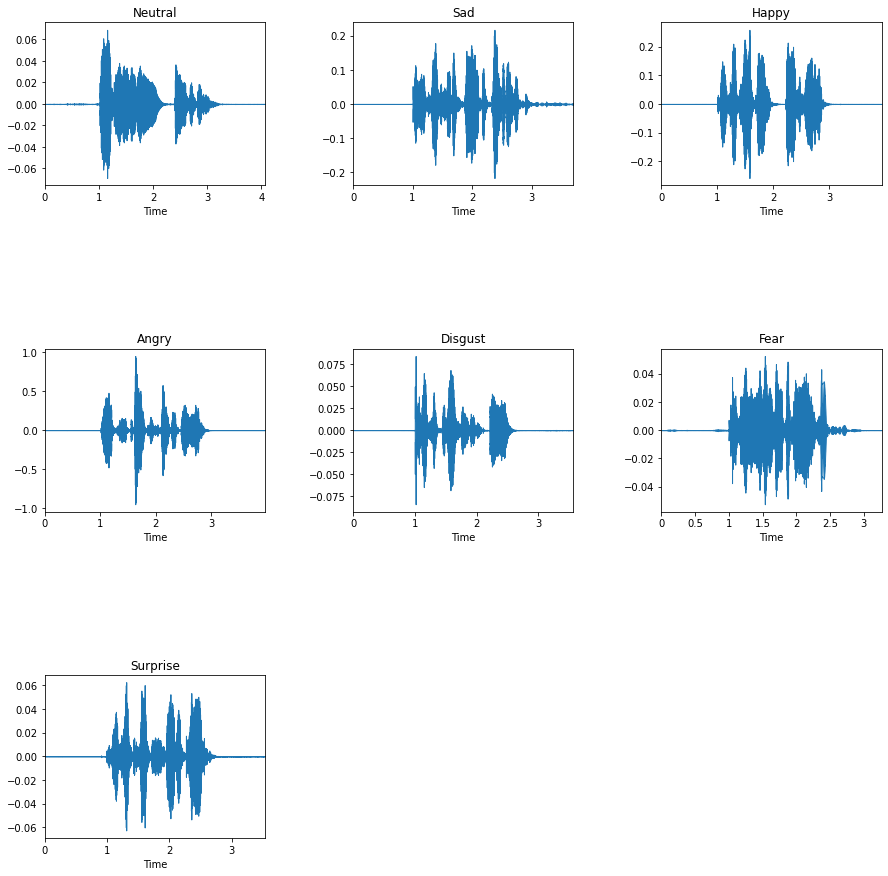

In [10]:
plot_all_emotion_waveforms('male')


### 2.2.2 COMPARATIVA DE EMOCIONES DE MUJER
Vemos el aspecto que tienen las emociones para la **voz femenina**


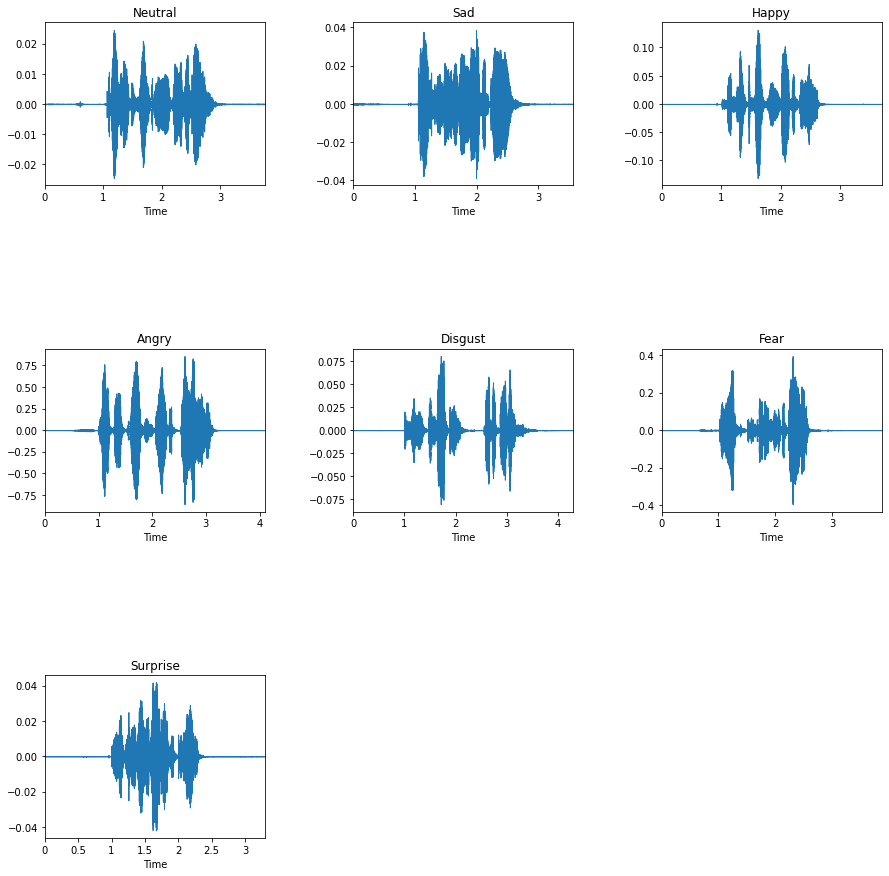

In [11]:
plot_all_emotion_waveforms('female')

Se puede observar en los resultados, que la se;al asociada a cada una de las emociones presenta diferencias con respecto a la voz femenina y la masculina. A simple vista no podemos hablar de unos cambios constantes en determinados puntos. Vemos que la *felicidad* masculina y femennina es expresada de una manera similar, al contrario, por ejemplo, de lo que ocurre con el *miedo*, donde en su version masculina presenta mas saltos entre sus picos de frecuencia. por lo que es algo que deberemos tener en cuenta en este analisis

# **3. EXTRACCION DE CARACTERISTICAS**

### Extracción de características con MFCC

In [12]:
def get_features(df):
  '''
  Extrae las caracteristicas de un conjunto de pistas de audio a 
  partir de un dataframe usando librosa

  Aguments
  ---------
    df : dataframe
    Dataframe que contiene el path donde se encuentra la pista de audio

  Return
  -------
   data: np.array 
   Caracteristicas extraidas

  '''
  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  for index in bar_data_range:
    data_features = get_features_single_file(df.path[index])
    data.loc[index] = [data_features]

  return data


def get_features_single_file(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, duration=2.5, sr=22050*2, offset=0.5)
  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  data_features = np.mean(mfcc, axis = 0)

  return data_features



def get_random_emotion(df, emotion):
  '''
  Devuelve el path de un archivo de audio aleatorio a partir de un dataframe.

  Aguments
  ---------
  df: dataframe
    Caracteristicas de la muestra de audio organizadas por emociones
  emotion: str
    Nombre de la emocion 
    
  Return
  -------
  '''
  if 'emotion' not in df:
    return -1

  aux_df = df[df['emotion'] == emotion]
  item = random.choice(aux_df.index.to_list())
  path = aux_df.path[item]

  return path

def plot_waves_comparative(df1, df2, df1_title = 'Wave 1', df2_title = 'Wave 2', title_ = 'Title'):
  '''
  Imprime la grafica de dos waveforms a partir de sus caracteristicas.

  Aguments
  ---------
  df1: dataframe
    Caracteristicas de la primera muestra de audio
  df2: dataframe
    Caracteristicas de la segunda muestra de audio
  df1_title: str, optional
    Titulo para la primera grafica
  df2_title: str, optional
    Titulo para la segunda grafica 
  title_: str, optional
    Titulo para la figura

  '''
  plt.figure(figsize=(20, 15))
  plt.subplot(3,1,1)
  plt.title(title_)
  plt.plot(df1, label= df1_title)
  plt.plot(df2, label= df2_title)
  plt.legend()


def plot_all_comparative_waveforms(rows = 3, cols = 3):
  '''


  Aguments
  ---------
  Return
  -------
  '''

  labels = list(EnglishSpeech_df['emotion'].unique())
  features_dict = dict()
  for label in labels:
    # Female
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], label)
    # female_feat = get_features_single_file(path)
    key = 'female_' + label
    features_dict[key] = get_features_single_file(path)
    # Male
    path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], label)
    # male_feat = get_features_single_file(path)
    key = 'male_' + label
    features_dict[key] = get_features_single_file(path)

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i, label in enumerate(labels):
    key = 'female_' + label
    df_fem = features_dict[key]
    key = 'male_' + label
    df_mal = features_dict[key]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.plot(df_fem, label= 'female')
    plt.plot(df_mal, label= 'male')
    plt.legend()



In [13]:
# Guardamos las caracteristicas a partir de la estructura que hemos construido antes
features_data = get_features(EnglishSpeech_df)
print(features_data)

100%|██████████| 1440/1440 [13:26<00:00,  1.79it/s]

                                                   data
0     [-66.05910681311283, -66.05910681311283, -66.0...
1     [-73.84224775864776, -73.84224775864776, -73.8...
2     [-61.85074892615189, -62.89585881547302, -63.8...
3     [-70.26853901183485, -70.26853901183485, -70.2...
4     [-69.05200902221408, -69.05200902221408, -69.0...
...                                                 ...
1435  [-59.85004278278616, -59.85004278278616, -59.8...
1436  [-58.23212314147993, -58.23212314147993, -58.2...
1437  [-56.94139761360669, -56.94139761360669, -56.9...
1438  [-48.669617015930115, -45.72232576407416, -46....
1439  [-55.25596532128967, -55.25596532128967, -55.1...

[1440 rows x 1 columns]


In [14]:
# features_data.head()
f_df = pd.DataFrame(features_data['data'].values.tolist())
f_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-65.682804,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-65.751525,-63.380963,-62.700762,-65.098389,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.059107,-66.002813,-61.924990,-59.585243,-56.340054,-54.956473,-55.591424,...,-55.764549,-58.545475,-55.988739,-56.975453,-61.780469,-65.383771,-63.935678,-63.328607,-62.011508,-61.251253,-62.367167,-62.563301,-61.352037,-63.539752,-64.852817,-61.058858,-60.734669,-62.970984,-65.925474,-66.059107,-66.059107,-65.233562,-64.616935,-65.550824,-66.059107,-66.059107,-65.296366,-61.711599,-60.360745,-60.373732,-57.540460,-55.827201,-57.742851,-59.797208,-60.976193,-62.663849,-64.574215,-63.783475,-61.517013,-58.217070
1,-73.842248,-73.842248,-73.842248,-73.720530,-73.842248,-73.842248,-73.842248,-73.304645,-72.807795,-73.842248,-73.842248,-73.318681,-65.748177,-64.292677,-63.901078,-62.007441,-61.668209,-60.353570,-62.795679,-71.039792,-67.588894,-70.090082,-71.926079,-72.205903,-73.842248,-71.767055,-69.865594,-65.621540,-62.510488,-60.178302,-61.991925,-64.299289,-65.288956,-67.775197,-66.402571,-64.903643,-62.787173,-58.825620,-54.061961,-53.111848,...,-30.143039,-30.706512,-30.394375,-29.729416,-30.308895,-29.539308,-30.008672,-29.881324,-30.892699,-33.100491,-30.836923,-30.755795,-30.185336,-31.663189,-33.846000,-34.118854,-36.499844,-38.370596,-39.913241,-41.742887,-42.856285,-43.770604,-44.719072,-45.199141,-46.888341,-48.836188,-49.847429,-49.986943,-49.796782,-51.918861,-51.597118,-50.530498,-53.475499,-54.207876,-51.526096,-52.561076,-54.772149,-56.335018,-57.500893,-56.567900
2,-61.850749,-62.895859,-63.831462,-60.553468,-60.822610,-62.074268,-64.890057,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-63.680493,-59.563391,-59.069228,-62.143885,-62.432298,-64.842635,-65.390719,-65.390719,-63.870670,-61.361367,-59.707895,-59.798948,-62.271982,-60.550753,-58.221989,-58.359528,-60.649240,-53.255684,-51.225755,-49.681643,-51.877787,-56.027065,-57.659992,-58.432911,-58.608313,-60.930635,-64.419700,-58.210065,...,-53.209364,-54.153309,-52.783723,-53.129264,-57.196295,-55.771369,-55.110695,-57.924317,-56.827615,-57.973215,-56.144128,-53.264212,-55.031011,-58.032765,-62.374458,-63.339923,-59.325737,-58.808514,-62.785079,-63.299223,-63.523276,-64.284761,-64.732945,-61.391405,-60.566310,-61.249635,-64.318772,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719,-65.390719
3,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.001543,-69.981668,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-70.268539,-66.097257,-63.398196,-68.260740,-70.268539,-69.666078,-68.817977,-66.116414,-63.903822,-68.622377,-70.268539,-69.642827,-68.421043,-70.044980,-67.233440,-66.351326,-68.504274,-66.578332,-62.981783,-62.694348,-65.907465,...,-40.011754,-39.581405,-41.080829,-41.835033,-43.329960,-44.811618,-46.607579,-45.475890,-48.727752,-51.779517,-51.438683,-52.644333,-54.618240,-56.557264,-56.229717,-53.642981,-52.772164,-51.569217,-54.047658,-55.942868,-54.383812,-54.098568,-52.374527,-51.011086,-53.335382,-55.216554,-57.184214,-60.705847,-57.998865,-57.543835,-58.802936,-57.448360,-58.897438,-58.751929,-57.406579,-60.079306,-63.427680,-62.639439,-61.083599,-60.235444
4,-69.052009,-69.052009,-69.052009,-69.052009,-69.052009,-68.755513,-69.052009,-69.052009,-69.052009,-68.359836,-68.879418,-69.052009,-68.494070,-67.110674,-66.995148,-68.018825,-66

In [15]:
features_complete_df = pd.concat((f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1)
features_complete_df = features_complete_df.fillna(0)

# Barajamos las filas para imrpimir una muestra 
random_aux = shuffle(features_complete_df)
random_aux.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,gender,emotion
843,-53.632311,-54.791677,-56.055036,-54.773722,-54.150093,-53.750178,-51.116457,-49.592087,-49.115330,-49.579231,-49.329014,-47.631065,-47.824511,-48.664318,-48.636683,-49.513436,-52.472191,-53.453816,-51.136610,-51.455916,-52.277067,-52.375055,-49.413134,-48.542668,-50.702634,-50.210173,-48.139248,-47.977089,-48.436781,-46.777478,-48.646168,-50.854538,-50.987339,-48.439247,-50.085047,-51.459575,-49.307881,-46.688122,-44.991065,-45.750567,...,-54.667232,-52.498480,-49.003740,-47.542591,-45.813540,-46.151491,-47.675162,-46.597321,-46.613939,-48.472282,-49.169097,-49.364094,-50.059940,-49.191871,-50.493841,-52.166555,-53.185572,-48.056915,-47.301575,-47.220748,-47.471554,-47.103309,-48.070019,-48.255886,-48.553430,-47.858758,-50.324185,-50.651155,-50.547058,-52.804447,-54.157169,-53.241722,-50.747064,-50.149085,-51.305387,-51.204655,-50.634962,-52.357971,male,neutral
1060,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.071825,-58.001836,-58.183443,-58.732024,-57.525385,-58.342596,-58.681375,-59.015453,-59.432632,-59.206359,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-59.147178,-58.006334,...,-38.528114,-39.696036,-36.170280,-33.046704,-34.701722,-34.825403,-37.112748,-40.042051,-40.207595,-43.089948,-42.903260,-45.338095,-41.446077,-37.934457,-39.810608,-41.091259,-39.962341,-41.134109,-39.200524,-38.559286,-41.601212,-42.356793,-42.289152,-44.094380,-47.033482,-46.693049,-47.480668,-47.246348,-44.589132,-47.246852,-48.395672,-47.873432,-49.259923,-48.560783,-49.604163,-51.576183,-57.678768,-59.147178,female,fear
297,-61.661472,-60.170420,-59.358380,-59.051334,-58.002507,-58.969386,-58.440333,-56.480740,-56.492057,-60.217806,-58.422610,-56.883768,-56.859699,-58.642666,-56.691240,-55.772561,-58.364913,-60.874355,-56.899823,-55.929999,-57.008656,-60.913139,-58.104047,-56.593546,-57.373928,-62.257937,-62.257937,-61.930953,-60.964128,-58.867100,-58.045673,-58.742684,-60.393953,-61.654467,-61.310470,-59.253346,-57.979372,-58.025219,-57.530715,-55.626464,...,-33.779171,-35.511292,-37.045209,-36.664170,-37.052858,-39.235186,-40.267808,-41.498533,-41.234792,-41.793745,-39.819520,-36.301959,-33.706893,-30.270102,-28.688446,-27.863548,-27.700241,-29.579336,-32.413662,-35.084272,-35.722921,-36.488733,-37.086887,-39.449226,-39.854174,-40.652040,-42.154845,-44.262139,-42.926235,-43.033169,-44.087511,-46.726472,-46.683797,-47.867283,-48.290803,-47.877523,-46.171692,-47.037851,male,surprise
1090,-50.435475,-50.339999,-50.184456,-50.938087,-51.128852,-51.297817,-51.640192,-51.818129,-51.968140,-52.406030,-52.379707,-53.568013,-54.477482,-54.449928,-54.439265,-54.296836,-54.624072,-54.411169,-54.939572,-53.692365,-56.016020,-57.704721,-56.712696,-56.804938,-56.486210,-55.073180,-53.772129,-54.107028,-54.069165,-52.181040,-53.481711,-56.133016,-60.462448,-57.209582,-53.743130,-53.218299,-50.218951,-50.208097,-50.903190,-52.303474,...,-36.684672,-35.011941,-34.835983,-31.775832,-28.780125,-27.260104,-26.352726,-26.122207,-27.196232,-28.634360,-28.812949,-29.787048,-31.448023,-31.614640,-32.654047,-32.567855,-33.961054,-34.793517,-35.688963,-37.296194,-40.655111,-39.211625,-38.976831,-40.197691,-41.882816,-42.438863,-42.074538,-43.230804,-45.126242,-47.440944,-48.225118,-45.810510,-41.774853,-35.583346,-29.013331,-25.798893,-22.760034,-22.443592,male,happy
578,-49.475294,-48.795417,-49.005618,-48.637348,-48.924687,-51.221731,-52.455493,-53.028300,-52.261420,-52.069188,-50.896369,-51.408727,-49.883988,-50.052780,-51.508797,-55.502698,-55.663278,-54.406409,

### Division del dataframe
Vamos a dividir el dataframe por el genero, para comprobar como afecta este a la prosodia en la voz femenina y masculina por separadas, dadas las mismas emociones en el analisis

In [16]:
male_features_df = features_complete_df[(features_complete_df['gender'] == 'male')]
female_features_df = features_complete_df[(features_complete_df['gender'] == 'female')]

### Comparativa
Ahora que podemos extraer las caracteristicas de las señales, vamos a comparar la misma emocion, (por ejemplo *enfado*) en la voz femenina y la masculina.


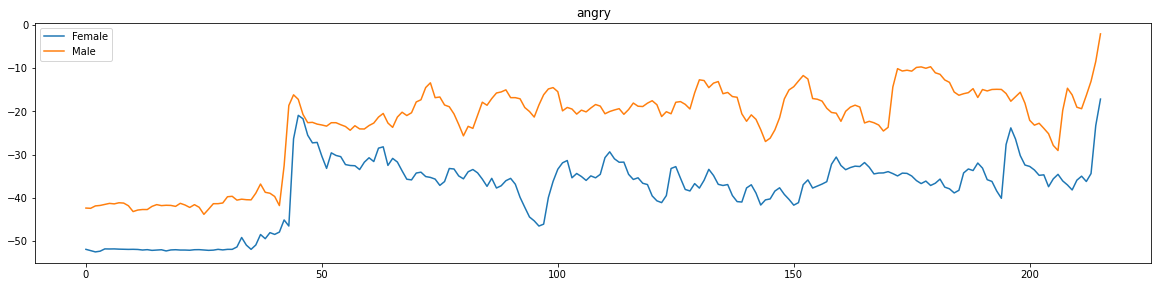

In [17]:
# Extraemos una muestra aleatoria para la emocion: enfado 
# Female
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'female'], 'angry')
female_feat = get_features_single_file(path)
# print(len(female_feat))
# Male
path = get_random_emotion(EnglishSpeech_df[EnglishSpeech_df['gender'] == 'male'], 'angry')
male_feat = get_features_single_file(path)
# print(len(male_feat))

plot_waves_comparative(female_feat, male_feat, "Female", "Male", "angry")



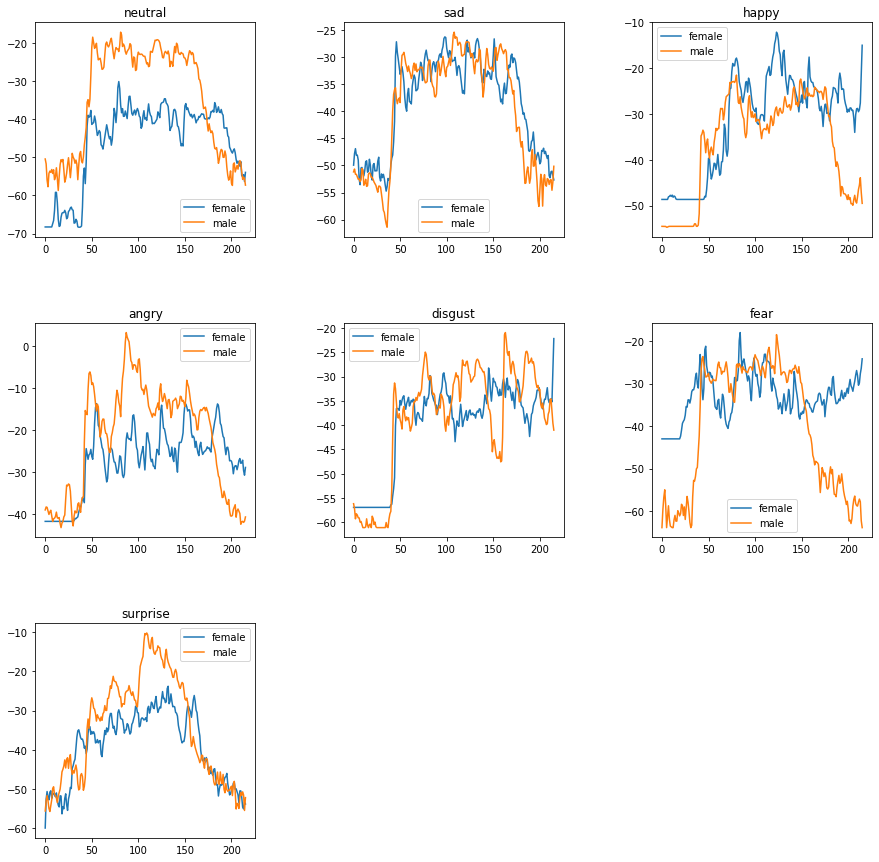

In [21]:
plot_all_comparative_waveforms()

# Preparación de los datos


In [18]:
def split_training_test(df, n_splits_=1, test_size_=0.25, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  @ Args

  @ Return
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test
  # return train_test_split(X, Y, stratify = Y, test_size=0.25)#X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento
  '''
  # Now because we are mixing up a few different data sources, it would be wise to normalise the data. 
  # This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, 
  # the problem used to be know as "exploding gradients".
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  
  '''
  # Lets few preparation steps to get it into the correct format for Keras 
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))

  # # Pickel the lb object for future use 
  # filename = 'labels'
  # outfile = open(filename,'wb')
  # pickle.dump(label_encoder, outfile)
  # outfile.close()

  # print(x_train_norm.shape)
  # print(label_encoder.classes_)

  return x_train_norm, y_train, x_test_norm, y_test, label_encoder



## Division de los datos en entrenamiento y test

In [23]:
# NOTA: Aqui estoy comprobando los datos que me da si divido entrenamiento y test con split de toda la vida

# # female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df)
# female_X_train.head()
# print(918 in female_X_train.index)

In [19]:
X_train, X_test, Y_train, Y_test = split_training_test(features_complete_df)
X_train.head()
print(X_train.shape)

(1080, 216)


In [20]:
# Comprobamos la distribución de las clases (emociones en nuestro caso)
Y_train.value_counts()

neutral     216
sad         144
angry       144
surprise    144
disgust     144
happy       144
fear        144
Name: emotion, dtype: int64

In [21]:
# Comprobamos que no hay valores NaN
X_train.isna().sum().sum()

0

### Normalizacion de los datos


In [22]:
X_train_norm, X_test_norm = data_normalization(X_train, X_test)
print(features_complete_df.shape)

# Comprobamos imprimiendo una muestra de los datos
indx = random.randint(0, len(features_complete_df))
X_train[indx:indx+10]

(1440, 218)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
1096,-60.312457,-59.178978,-59.345923,-59.109708,-59.874049,-61.081006,-60.630842,-59.275220,-60.600039,-61.966847,-59.942245,-60.477782,-65.722732,-67.324435,-66.825311,-67.814374,-67.814374,-67.814374,-67.814374,-64.336583,-64.761425,-67.814374,-67.814374,-66.950083,-63.044228,-56.863438,-54.367818,-53.214908,-53.593285,-50.327397,-50.095714,-50.995953,-45.747129,-43.297273,-45.829996,-49.368255,-43.075797,-39.378646,-39.505178,-42.168978,...,-48.397371,-48.877074,-49.341729,-48.682673,-50.203335,-54.562548,-56.463618,-53.466673,-49.148847,-46.376573,-37.649643,-31.195507,-29.496520,-31.391715,-31.912501,-31.077593,-28.492501,-28.472975,-30.699196,-34.372817,-35.796125,-36.183039,-37.290892,-37.461485,-36.789369,-36.494267,-36.981378,-39.394828,-41.059664,-40.568790,-41.402647,-42.692111,-43.000485,-43.563346,-43.154459,-45.787697,-46.813012,-46.434553,-47.423605,-48.097394
180,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.527835,-66.555406,-66.535248,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.488894,-66.542182,-64.367938,-63.755297,-64.885048,-63.847873,-64.089142,-59.608068,...,-54.841173,-57.347858,-60.855717,-59.530870,-60.120696,-61.941998,-61.155292,-61.731273,-59.650807,-58.647602,-60.566932,-62.377715,-62.571525,-64.756974,-63.482988,-62.114772,-63.191951,-61.900023,-60.654149,-62.939872,-65.117196,-64.317477,-63.649084,-63.262181,-63.174393,-64.643360,-62.285867,-62.611799,-65.420265,-63.076108,-61.150305,-62.122575,-64.444821,-65.316135,-65.285874,-65.366224,-64.971610,-64.158166,-64.913824,-66.488894
453,-47.877658,-47.763940,-47.889495,-46.266450,-45.837099,-44.398256,-44.517259,-45.674146,-44.966586,-46.908153,-46.942075,-46.381442,-46.336255,-44.410992,-44.528219,-46.623256,-46.558465,-46.449778,-45.008740,-44.750232,-46.273876,-45.083548,-45.350035,-43.998924,-44.628784,-45.953412,-45.472735,-45.151823,-46.776266,-45.981957,-47.192001,-45.374445,-43.794097,-45.007040,-46.271433,-46.989053,-47.867564,-46.561836,-43.820392,-41.680372,...,-26.902271,-26.892884,-27.443604,-26.946314,-27.074361,-26.670214,-26.522200,-26.794158,-25.367929,-24.235609,-25.435765,-26.248707,-29.990096,-30.705453,-30.747963,-29.891600,-30.822382,-30.278996,-30.709383,-31.153836,-31.646182,-32.151531,-32.630116,-34.223967,-35.802824,-36.557443,-34.551295,-34.756379,-33.734714,-33.691337,-36.015923,-34.573830,-35.279389,-37.257520,-38.419936,-39.291695,-39.118039,-40.683997,-43.707535,-44.986389
497,-56.167235,-54.822982,-53.183365,-51.706638,-51.811565,-52.444001,-51.902466,-51.067408,-52.179848,-53.196882,-51.355778,-51.753592,-53.868890,-54.084058,-54.200270,-54.578895,-50.888746,-48.763869,-48.823141,-49.945347,-51.525982,-51.208770,-51.819820,-52.266001,-53.756189,-57.444225,-57.719689,-61.711281,-62.313664,-61.967832,-61.412350,-60.744880,-62.011212,-63.434954,-58.870881,-59.806718,-62.135550,-64.466685,-61.573313,-53.423824,...,-32.076227,-31.854387,-32.014334,-34.474024,-36.825586,-35.349274,-36.224095,-40.723325,-42.176606,-43.521302,-41.979842,-39.138162,-39.073991,-41.256502,-33.122229,-29.528159,-28.499998,-28.384610,-32.005168,-36.203469,-35.833651,-36.998239,-39.921221,-42.614528,-41.651486,-42.899658,-47.122153,-48.436480,-46.410739,-37.419486,-33.949507,-34.192957,-37.704201,-41.252357,-41.273095,-42.623664,-45.869731,-46.939657,-46.898289,-47.584048
901,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-65.160072,-64.498533,-62.923521,-63.242306,-64.630258,-64

### Categorizacion de los datos

In [23]:
X_train, Y_train, X_test, Y_test, labels_whole = data_to_categorical(X_train_norm, Y_train, X_test_norm, Y_test)

In [24]:
print(labels_whole.classes_)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


### Cambio de dimension

In [25]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape)

(1080, 216, 1)


Comprobamos que despues de los cambios hay unas dimensiones coherentes

In [26]:
print("X Train: {} --> Y Train: {}".format(X_train.shape, Y_train.shape))
print("\nX Test: {} --> Y Test: {}".format(X_test.shape, Y_test.shape))

X Train: (1080, 216, 1) --> Y Train: (1080, 7)

X Test: (360, 216, 1) --> Y Test: (360, 7)


### Preparación de los datos para _Female_

In [27]:
# 1. Division de los datos: Entrenamiento y Test
female_X_train, female_X_test, female_Y_train, female_Y_test =split_training_test(female_features_df) # with StratifiedShuffleSplit

# 2. Normalizacion
x_train_female_norm, x_test_female_norm = data_normalization(female_X_train, female_X_test)
print(x_train_female_norm.shape)

# 3. Categorización
female_X_train, female_Y_train, female_X_test, female_Y_test, labels_female = data_to_categorical(x_train_female_norm, female_Y_train, x_test_female_norm, female_Y_test)
print(labels_female.classes_)

# 4. Cambio de Dimensión
X_train_female = np.expand_dims(female_X_train, axis=2)
X_test_female = np.expand_dims(female_X_test, axis=2)

print("\nTrain size: {}\nTest size:{}".format(X_train_female.shape, X_test_female.shape))
print("\nTrain size: {}\nTest size:{}".format(female_Y_train.shape, female_Y_test.shape))

(540, 216)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Train size: (540, 216, 1)
Test size:(180, 216, 1)

Train size: (540, 7)
Test size:(180, 7)


### Preparación de los datos para _Male_


In [32]:
# 1. Division de los datos: Entrenamiento y Test
male_X_train, male_X_test, male_Y_train, male_Y_test =split_training_test(male_features_df)
male_X_train.head()

# 2. Normalizacion
x_train_male_norm, x_test_male_norm = data_normalization(male_X_train, male_X_test)
print(x_train_male_norm.shape)

# 3. Categorización
male_X_train, male_X_test, male_Y_train, male_Y_test, labels_male = data_to_categorical(x_train_male_norm, male_Y_train, x_test_male_norm, male_Y_test)
print(labels_male.classes_)

# 4. Cambio de Dimensión
X_train_male = np.expand_dims(X_train, axis=2)
X_test_male = np.expand_dims(X_test, axis=2)

print("\nTrain size: {}\nTest size:{}".format(X_train_female.shape, X_test_female.shape))

(540, 216)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


# El modelo
## Diseño del modelo

In [28]:
def model_cnn(x_train, n_classes):
  '''
  '''
  print("Model for {} classes\n".format(n_classes));

  model = Sequential()
  # 1 Capa
  model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  
  model.add(Activation('relu'))
  # 2 Capa
  model.add(Conv1D(256, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))
  # 3 Capa
  model.add(Conv1D(128, 8, padding='same'))
  model.add(Activation('relu'))
  # 4 Capa
  model.add(Conv1D(128, 8, padding='same'))
  model.add(Activation('relu'))
  # 5 Capa
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # # 6 Capa
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(Dropout(0.25))
  # model.add(MaxPooling1D(pool_size=(8)))
  # # 6 Capa
  # model.add(Conv1D(64, 8, padding='same'))
  # model.add(Activation('relu'))
  # # 7 Capa
  # model.add(Conv1D(64, 8, padding='same'))
  # model.add(Activation('relu'))
  # 8 Capa
  model.add(Flatten())
  model.add(Dense(n_classes)) # Target class number
  model.add(Activation('softmax'))

  return model

# def model_rnn():


## Compilación del modelo

In [29]:
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# X_train_female , X_test_female
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()


Model for 7 classes

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None,

In [30]:
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt,
              metrics=['accuracy'])

history = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test_female, female_Y_test))

Epoch 1/100
34/34 [==============================] - 13s 336ms/step - loss: 2.0776 - accuracy: 0.1893 - val_loss: 1.9368 - val_accuracy: 0.2278
Epoch 2/100
34/34 [==============================] - 11s 320ms/step - loss: 1.7382 - accuracy: 0.3288 - val_loss: 1.9233 - val_accuracy: 0.2944
Epoch 3/100
34/34 [==============================] - 11s 319ms/step - loss: 1.6394 - accuracy: 0.3790 - val_loss: 1.9080 - val_accuracy: 0.3667
Epoch 4/100
34/34 [==============================] - 11s 319ms/step - loss: 1.5338 - accuracy: 0.4413 - val_loss: 1.8924 - val_accuracy: 0.4167
Epoch 5/100
34/34 [==============================] - 11s 319ms/step - loss: 1.4768 - accuracy: 0.4761 - val_loss: 1.8739 - val_accuracy: 0.4333
Epoch 6/100
34/34 [==============================] - 11s 323ms/step - loss: 1.4141 - accuracy: 0.4824 - val_loss: 1.8534 - val_accuracy: 0.4389
Epoch 7/100
34/34 [==============================] - 11s 319ms/step - loss: 1.4075 - accuracy: 0.5105 - val_loss: 1.8311 - val_accuracy:

### Persistencia del modelo
Guardamos el modelo para un uso posterior sin necesidad de volverlo a entrenar


In [31]:
# detectar que modelo acaba de ejecutarse para guardarlo automaticamente?
model.save('model_english_female_SER.h5')

## Validación del modelo

2/2 [==============================] - 1s 219ms/step - loss: 1.2595 - accuracy: 0.5722
Loss, Accuracy:  [1.2594656944274902, 0.5722222328186035]


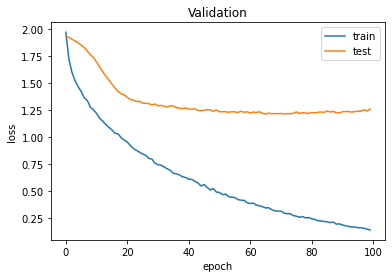

In [33]:
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss, Accuracy: ", score)

# Mostramos la grafica del loss y accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Predicción

In [38]:
model.predict(X_test, batch_size = 16, verbose = 1)

23/23 [==============================] - 2s 70ms/step


array([[0.0000000e+00, 0.0000000e+00, 4.1528581e-32, ..., 1.0000000e+00,
        1.3548003e-22, 1.5894362e-37],
       [2.2955489e-28, 1.4436150e-21, 1.9394684e-09, ..., 4.7972840e-01,
        5.2027166e-01, 1.8790870e-17],
       [3.5566003e-25, 2.5261590e-31, 1.2032555e-17, ..., 9.9999976e-01,
        2.9026174e-07, 8.5061001e-18],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        2.2007801e-28, 0.0000000e+00],
       [0.0000000e+00, 6.2461567e-38, 9.7364196e-26, ..., 1.0000000e+00,
        4.8965412e-20, 1.2709111e-24],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.3309847e-23, 0.0000000e+00]], dtype=float32)